## Notebook to create a regional rainfall-runoff model using an LSTM network for CAMELS CH Dataset

**Description**

The following notebook contains the code to create, train, validate and test a rainfall-runoff model using a LSTM 
network architecture. The code allows for the creation of single-basin models, but it is conceptualized to create 
regional models. The code is intended as an intial introduction to the topic, in which we prioritized interpretability
over modularity. The model generated in this code makes use of the CAMELS CH Datset [2]

The logic of the code is heavily based on [Neural Hydrology](https://doi.org/10.21105/joss.04050)[1]. For a more 
flexible, robust and modular implementation of deep learning method in hydrological modeling we advice the use of Neural 
Hydrology. 

**Authors:**
- Eduardo Acuna Espinoza (eduardo.espinoza@kit.edu)
- Ralf Loritz
- Manuel Álvarez Chaves

**Adaptations:**
- Sanika Baste (sanika.baste@kit.edu)

**References:**

[1]: "F. Kratzert, M. Gauch, G. Nearing and D. Klotz: NeuralHydrology -- A Python library for Deep Learning research in hydrology. Journal of Open Source Software, 7, 4050, doi: 10.21105/joss.04050, 2022"

[2]: Höge, M., Kauzlaric, M., Siber, R., Schönenberger, U., Horton, P., Schwanbeck, J., Floriancic, M. G., Viviroli, D., Wilhelm, S., Sikorska-Senoner, A. E., Addor, N., Brunner, M., Pool, S., Zappa, M., and Fenicia, F.: CAMELS-CH: hydro-meteorological time series and landscape attributes for 331 catchments in hydrologic Switzerland, Earth Syst. Sci. Data, 15, 5755–5784, https://doi.org/10.5194/essd-15-5755-2023, 2023.

In [1]:
#Import necessary packages
import sys
import pandas as pd
import numpy as np
import time
import pickle
import random
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader

sys.path.append("../aux_functions")
sys.path.append("../datasetzoo")
sys.path.append("../modelzoo")

# Import classes and functions from other files
from functions_training import nse_basin_averaged
from functions_evaluation import nse
from functions_aux import create_folder, set_random_seed, write_report

# Import dataset to use
from camelsch import CAMELS_CH

# Import model
from cudalstm import CudaLSTM
from customlstm import customLSTM

Part 1. Initialize information

In [2]:
# Define experiment nae
experiment_name = "LSTM_CAMELS_CH"

# paths to access the information
path_entities = "../../data/basin_id/basins_camels_ch_331.txt"
path_data = "../../data/CAMELS_CH"

# dynamic forcings and target
dynamic_input = ['precipitation(mm/d)', 'temperature_min(degC)', 'temperature_max(degC)', 'rel_sun_dur(%)']
target = ['discharge_spec(mm/d)']

# static attributes that will be used
static_input = ['area',
                'elev_mean',
                'slope_mean',
                'sand_perc',
                'silt_perc',
                'clay_perc',
                'porosity',
                'conductivity',
                'glac_area',
                'dwood_perc',
                'ewood_perc',
                'crop_perc',
                'urban_perc',
                'reservoir_cap',
                'p_mean',
                'pet_mean',
                'p_seasonality',
                'frac_snow',
                'high_prec_freq',
                'low_prec_freq',
                'high_prec_dur',
                'low_prec_dur']

# time periods
training_period = ['1995-10-01','2005-09-30']
validation_period = ['2005-10-01','2010-09-30']
testing_period = ['2010-10-01','2011-09-30']

model_hyper_parameters = {
    "input_size_lstm": len(dynamic_input) + len(static_input),
    "no_of_layers":1,  
    "seq_length": 365,
    "hidden_size": 64,
    "batch_size_training":256,
    "batch_size_evaluation":1024,
    "no_of_epochs": 10,             
    "drop_out_rate": 0.4, 
    "learning_rate": 0.001,
    "adapt_learning_rate_epoch": 10,
    "adapt_gamma_learning_rate": 0.5,
    "set_forget_gate":3,
    "validate_every": 10,
    "validate_n_random_basins": 5
    }

# device to train the model
running_device = "gpu" #cpu or gpu

# define random seed
seed = 42

# colorblind friendly palette for plotting
color_palette = {"observed": "#1f78b4","simulated": "#ff7f00"}

In [3]:
# Create folder to store the results
path_save_folder = "../results/"+experiment_name
create_folder(folder_path=path_save_folder)

Folder '../results/LSTM_CAMELS_CH' created successfully.


In [4]:
# check if model will be run in gpu or cpu and define device
if running_device == "gpu":
    print(torch.cuda.get_device_name(0))
    device= f'cuda:0'
elif running_device == "cpu":
    device = "cpu"

Tesla V100-SXM2-32GB


Part 2. Create dataset and dataloader for training

In [7]:
# Dataset training
training_dataset = CAMELS_CH(dynamic_input= dynamic_input,
                             target= target, 
                             sequence_length= model_hyper_parameters["seq_length"],
                             time_period= training_period,
                             path_data= path_data,
                             path_entities= path_entities,
                             static_input= static_input,
                             check_NaN= True)

training_dataset.calculate_basin_std()
training_dataset.calculate_global_statistics(path_save_scaler=path_save_folder)
training_dataset.standardize_data()

In [8]:
# Dataloader training
train_loader = DataLoader(dataset = training_dataset, 
                          batch_size = model_hyper_parameters["batch_size_training"],
                          shuffle = True,
                          drop_last = True)

print("Batches in training: ", len(train_loader))
sample = next(iter(train_loader))
print(f'x_lstm: {sample["x_lstm"].shape} | y_obs: {sample["y_obs"].shape} | basin_std: {sample["basin_std"].shape}')

Batches in training:  3046
x_lstm: torch.Size([256, 365, 26]) | y_obs: torch.Size([256, 1, 1]) | basin_std: torch.Size([256, 1, 1])


Part 3. Create dataset for validation

In [9]:
# We will create an individual dataset per basin. This will give us more flexibility
entities_ids = np.loadtxt(path_entities, dtype="str").tolist()
validation_dataset = {}

for entity in entities_ids:
    dataset = CAMELS_CH(dynamic_input= dynamic_input,
                        target= target, 
                        sequence_length= model_hyper_parameters["seq_length"],
                        time_period= validation_period,
                        path_data= path_data,
                        entity= entity,
                        static_input= static_input,
                        check_NaN= False)
    
    dataset.scaler = training_dataset.scaler
    dataset.standardize_data(standardize_output=False)
    validation_dataset[entity]= dataset

Part 4. Train LSTM

In [11]:
# construct model
set_random_seed(seed=seed)
lstm_model = CudaLSTM(hyperparameters=model_hyper_parameters).to(device)

# optimizer
optimizer = torch.optim.Adam(lstm_model.parameters(),
                             lr=model_hyper_parameters["learning_rate"])
    
# define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                            step_size=model_hyper_parameters["adapt_learning_rate_epoch"],
                                            gamma=model_hyper_parameters["adapt_gamma_learning_rate"])

# set forget gate to 3 to ensure that the model is capable to learn long term dependencies
lstm_model.lstm.bias_hh_l0.data[model_hyper_parameters["hidden_size"]:2 * model_hyper_parameters["hidden_size"]]=\
    model_hyper_parameters["set_forget_gate"]

training_time = time.time()
# Loop through the different epochs
for epoch in range(1, model_hyper_parameters["no_of_epochs"]+1):
    
    epoch_start_time = time.time()
    total_loss = []
    # Training -------------------------------------------------------------------------------------------------------
    lstm_model.train()
    for sample in train_loader: 
        optimizer.zero_grad() # sets gradients of weigths and bias to zero
        pred  = lstm_model(sample["x_lstm"].to(device)) # forward call
        
        loss = nse_basin_averaged(y_sim=pred["y_hat"], 
                                  y_obs=sample["y_obs"].to(device), 
                                  per_basin_target_std=sample["basin_std"].to(device))
        
        loss.backward() # backpropagates
        optimizer.step() #update weights
        total_loss.append(loss.item())
        
        # remove from cuda
        del sample["x_lstm"], sample["y_obs"], sample["basin_std"], pred
        torch.cuda.empty_cache()
        
    #training report  
    report = f'Epoch: {epoch:<2} | Loss training: {"%.3f "% (np.mean(total_loss))}'
    
    # Validation -----------------------------------------------------------------------------------------------------
    if epoch % model_hyper_parameters["validate_every"] == 0:
        lstm_model.eval()
        validation_results = {}
        with torch.no_grad():
            # If we define validate_n_random_basins as 0 or negative, we take all the basins
            if model_hyper_parameters["validate_n_random_basins"] <= 0:
                validation_basin_ids = validation_dataset.keys()
            else:
                keys = list(validation_dataset.keys())
                validation_basin_ids = random.sample(keys, model_hyper_parameters["validate_n_random_basins"])
            
            # go through each basin that will be used for validation
            for basin in validation_basin_ids:
                loader = DataLoader(dataset=validation_dataset[basin], 
                                    batch_size=model_hyper_parameters["batch_size_evaluation"], 
                                    shuffle=False, 
                                    drop_last = False)
                
                df_ts = pd.DataFrame()
                for sample in loader:
                    pred  = lstm_model(sample["x_lstm"].to(device)) 
                    # backtransformed information
                    y_sim = pred["y_hat"]* validation_dataset[basin].scaler["y_std"].to(device) +\
                        validation_dataset[basin].scaler["y_mean"].to(device)

                    # join results in a dataframe and store them in a dictionary (is easier to plot later)
                    df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                                       "y_sim": y_sim.flatten().cpu().detach()}, 
                                      index=pd.to_datetime(sample["date"]))

                    df_ts = pd.concat([df_ts, df], axis=0)

                    # remove from cuda
                    del pred, y_sim
                    torch.cuda.empty_cache()       
                
                validation_results[basin] = df_ts
                 
            #average loss validation
            loss_validation = nse(df_results=validation_results)
            report += f'| Loss validation: {"%.3f "% (loss_validation)}'

    
    # save model after every epoch
    path_saved_model = path_save_folder+"/epoch_" + str(epoch)
    torch.save(lstm_model.state_dict(), path_saved_model)
            
    # print epoch report
    report += f'| Epoch time: {"%.1f "% (time.time()-epoch_start_time)} s | LR:{"%.5f "% (optimizer.param_groups[0]["lr"])}'
    print(report)
    write_report(file_path=path_save_folder+"/run_progress.txt", text=report)
    # modify learning rate
    scheduler.step()

# print final report
report = f'Total training time: {"%.1f "% (time.time()-training_time)} s'
print(report)
write_report(file_path=path_save_folder+"/run_progress.txt", text=report)   

Epoch: 1  | Loss training: 0.012 | Epoch time: 86.4  s | LR:0.00100 
Epoch: 2  | Loss training: 0.007 | Epoch time: 80.7  s | LR:0.00100 
Epoch: 3  | Loss training: 0.005 | Epoch time: 80.9  s | LR:0.00100 
Epoch: 4  | Loss training: 0.005 | Epoch time: 80.5  s | LR:0.00100 
Epoch: 5  | Loss training: 0.005 | Epoch time: 78.8  s | LR:0.00100 
Epoch: 6  | Loss training: 0.004 | Epoch time: 79.8  s | LR:0.00100 
Epoch: 7  | Loss training: 0.004 | Epoch time: 80.5  s | LR:0.00100 
Epoch: 8  | Loss training: 0.004 | Epoch time: 80.2  s | LR:0.00100 
Epoch: 9  | Loss training: 0.004 | Epoch time: 80.6  s | LR:0.00100 
Epoch: 10 | Loss training: 0.004 | Loss validation: 0.828 | Epoch time: 81.3  s | LR:0.00100 
Total training time: 809.8  s


Part 5. Test LSTM

In [12]:
# In case I already trained an LSTM I can re-construct the model
lstm_model = CudaLSTM(hyperparameters=model_hyper_parameters).to(device)
lstm_model.load_state_dict(torch.load(path_save_folder + "/epoch_10", map_location=device))

# In case I already trained an LSTM I can re-construct the model
lstm_model_inspect = customLSTM(hyperparameters=model_hyper_parameters).to(device)
lstm_model_inspect.copy_weights(lstm_model)  # copy the CudaLSTM weights into the CustomLSTM

In [13]:
# We will create an individual dataset per basin. This will give us more flexibility
#path_entities = "../../data/basin_id/basins_camels_gb_lees.txt"
entities_ids = np.loadtxt(path_entities, dtype="str").tolist()
testing_dataset = {}

# We can read a previously stored scaler or use the one from the training dataset we just generated
#scaler = training_dataset.scaler
with open(path_save_folder + "/scaler.pickle", "rb") as file:
    scaler = pickle.load(file)

for entity in entities_ids:
    dataset = CAMELS_CH(dynamic_input= dynamic_input,
                        target= target, 
                        sequence_length= model_hyper_parameters["seq_length"],
                        time_period= testing_period,
                        path_data= path_data,
                        entity= entity,
                        static_input= static_input,
                        check_NaN= False)
    
    dataset.scaler = scaler
    dataset.standardize_data(standardize_output=False)
    testing_dataset[entity]= dataset

In [14]:
# testing CudaLSTM

lstm_model.eval()
test_results = {}
with torch.no_grad():
    for basin, dataset in testing_dataset.items():
        loader = DataLoader(dataset = dataset, 
                            batch_size = model_hyper_parameters["batch_size_evaluation"], 
                            shuffle = False, 
                            drop_last = False) 
        df_ts = pd.DataFrame()
        for sample in loader:
            pred  = lstm_model(sample["x_lstm"].to(device)) 
            # backtransformed information
            y_sim = pred["y_hat"]* dataset.scaler["y_std"].to(device) + dataset.scaler["y_mean"].to(device)

            # join results in a dataframe and store them in a dictionary (is easier to plot later)
            df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                                "y_sim": y_sim.flatten().cpu().detach()}, 
                                index=pd.to_datetime(sample["date"]))

            df_ts = pd.concat([df_ts, df], axis=0)

            # remove from cuda
            del pred, y_sim
            torch.cuda.empty_cache()       
        
        test_results[basin] = df_ts

# Save results as a pickle file
with open(path_save_folder+"/test_results.pickle", "wb") as f:
   pickle.dump(test_results, f)

In [15]:
# testing customLSTM

lstm_model_inspect.eval()
inspect_results = {}

with torch.no_grad():
    for basin, dataset in testing_dataset.items():
        loader = DataLoader(dataset = dataset, 
                            batch_size = model_hyper_parameters["batch_size_evaluation"], 
                            shuffle = False, 
                            drop_last = False)
        print("Batches in testing: ", len(loader))

        inspectmodel_output = []
        df_ts = pd.DataFrame()

        for sample in loader:
            # using customLSTM
            pred_inspect  = lstm_model_inspect(sample["x_lstm"].transpose(0, 1).to(device))

            y_sim = pred_inspect["y_hat"]* dataset.scaler["y_std"].to(device) + dataset.scaler["y_mean"].to(device)

            # join results in a dataframe and store them in a dictionary (is easier to plot later)
            df = pd.DataFrame({"y_obs": sample["y_obs"].flatten().cpu().detach(), 
                                "y_sim": y_sim[:, -1, :].flatten().cpu().detach()}, 
                                index=pd.to_datetime(sample["date"]))

            df_ts = pd.concat([df_ts, df], axis=0)

            _output = {"h_n": pred_inspect["h_n"].cpu().detach(), 
                                "c_n": pred_inspect["c_n"].cpu().detach(),
                                "i":pred_inspect["i"].cpu().detach(),
                                "f":pred_inspect["f"].cpu().detach(),
                                "g":pred_inspect["g"].cpu().detach(),
                                "o":pred_inspect["o"].cpu().detach(),
                                "y_hat":pred_inspect["y_hat"].cpu().detach()}

            inspectmodel_output.append(_output)

            del pred_inspect
            torch.cuda.empty_cache()

        inspect_results[basin] = inspectmodel_output
        del inspectmodel_output
        print('Testing using CustomLSTM complete for ' + str(basin))

# Save results as a pickle file
with open(path_save_folder+"/test_results_inspection.pickle", "wb") as f:
   pickle.dump(inspect_results, f)

Batches in testing:  1
Testing using CustomLSTM complete for 2004
Batches in testing:  1
Testing using CustomLSTM complete for 2007
Batches in testing:  1
Testing using CustomLSTM complete for 2009
Batches in testing:  1
Testing using CustomLSTM complete for 2011
Batches in testing:  1
Testing using CustomLSTM complete for 2014
Batches in testing:  1
Testing using CustomLSTM complete for 2016
Batches in testing:  1
Testing using CustomLSTM complete for 2017
Batches in testing:  1
Testing using CustomLSTM complete for 2018
Batches in testing:  1
Testing using CustomLSTM complete for 2019
Batches in testing:  1
Testing using CustomLSTM complete for 2020
Batches in testing:  1
Testing using CustomLSTM complete for 2021
Batches in testing:  1
Testing using CustomLSTM complete for 2022
Batches in testing:  1
Testing using CustomLSTM complete for 2023
Batches in testing:  1
Testing using CustomLSTM complete for 2024
Batches in testing:  1
Testing using CustomLSTM complete for 2025
Batches in

Part 6. Initial analysis

In [ ]:
# In case we already ran our model
#with open(path_save_folder+"/test_results.pickle", "rb") as f:
#    test_results = pickle.load(f)

In [16]:
# Loss testing
loss_testing = nse(df_results=test_results, average=False)
df_NSE = pd.DataFrame(data={"basin_id": testing_dataset.keys(), "NSE": np.round(loss_testing,3)})
df_NSE = df_NSE.set_index("basin_id")
df_NSE.to_csv(path_save_folder+"/NSE_669.csv", index=True, header=True)

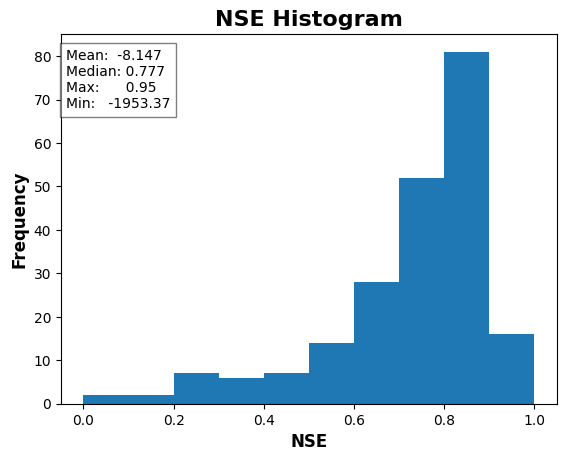

In [17]:
# Plot the histogram
plt.hist(df_NSE["NSE"], bins=[0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1])

# Add NSE statistics to the plot
plt.text(0.01, 0.8, f'Mean: {"%.3f" % df_NSE["NSE"].mean():>7}\nMedian: {"%.3f" % df_NSE["NSE"].median():>0}\nMax: {"%.2f" % df_NSE["NSE"].max():>9}\nMin: {"%.2f" % df_NSE["NSE"].min():>10}',
         transform=plt.gca().transAxes, bbox=dict(facecolor="white", alpha=0.5))

# Format plot
plt.rcParams["figure.figsize"] = (20, 5)
plt.xlabel("NSE", fontsize=12, fontweight="bold")
plt.ylabel("Frequency", fontsize=12, fontweight="bold")
plt.title("NSE Histogram", fontsize=16, fontweight="bold")
#plt.savefig(save_folder+"/NSE_LSTM_Histogram.png", bbox_inches="tight", pad_inches=0)
plt.show()

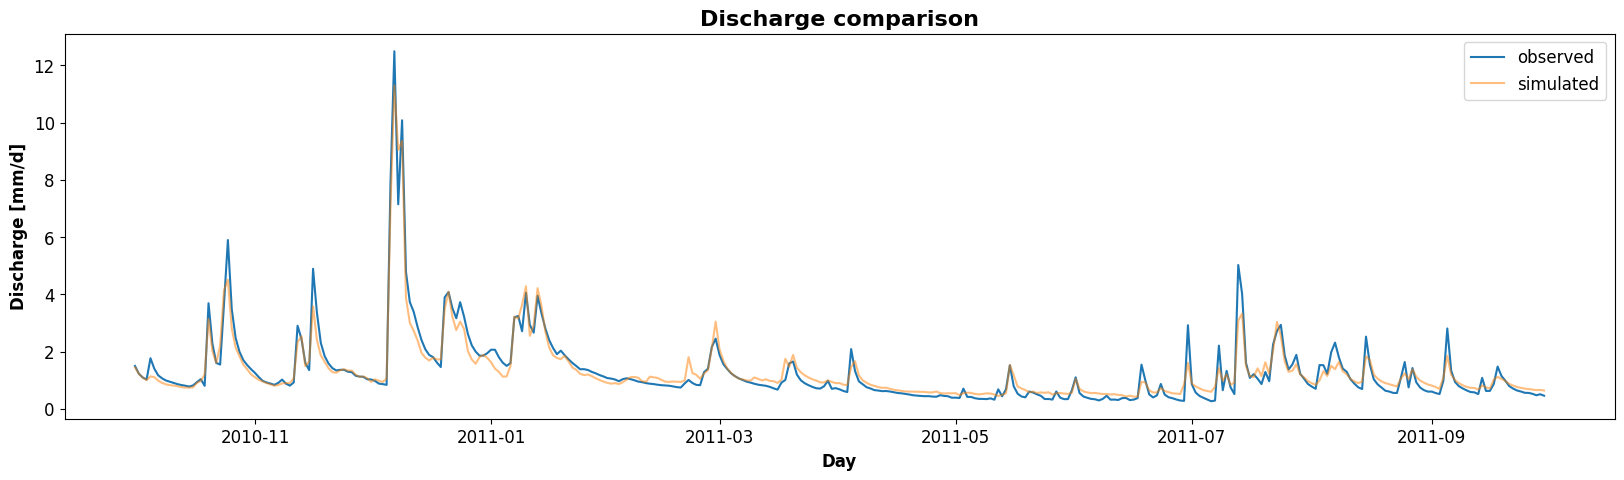

In [19]:
# Plot simulated and observed discharges
basin_to_analyze = "2386"

plt.plot(test_results[basin_to_analyze]["y_obs"], label="observed", color=color_palette["observed"])
plt.plot(test_results[basin_to_analyze]["y_sim"], label="simulated", alpha=0.5, color=color_palette["simulated"])

# Format plot
plt.xlabel("Day", fontsize=12, fontweight="bold")
plt.ylabel("Discharge [mm/d]", fontsize=12, fontweight="bold")
plt.title("Discharge comparison", fontsize=16, fontweight="bold")
plt.tick_params(axis="both", which="major", labelsize=12)
plt.legend(loc="upper right",fontsize=12)
plt.show()
#plt.savefig(save_folder+"/Model_Comparison.png", bbox_inches="tight", pad_inches=0)

Part 7: Inspecting LSTM activations and states

In [96]:
# Concatenate all batches into one tensor that contains the final time step of each sample.
# basin to analyse = 2386

inspectmodel_output = inspect_results[basin_to_analyze]
cell_states = torch.cat([out['c_n'][:, -1, :] for out in inspectmodel_output], dim=0).numpy()

# Load the forcings input for the corresponding date range
date_range = pd.date_range(testing_period[0], testing_period[1], freq='1D')

# loading input data
from pathlib import Path
path_timeseries = Path(path_data) / 'timeseries' / 'observation_based' / f'CAMELS_CH_obs_based_{basin_to_analyze}.csv'
# load time series
df = pd.read_csv(path_timeseries)
df = df.set_index('date')
df.index = pd.to_datetime(df.index, format="%Y-%m-%d")
swe = df['swe(mm)'][date_range]

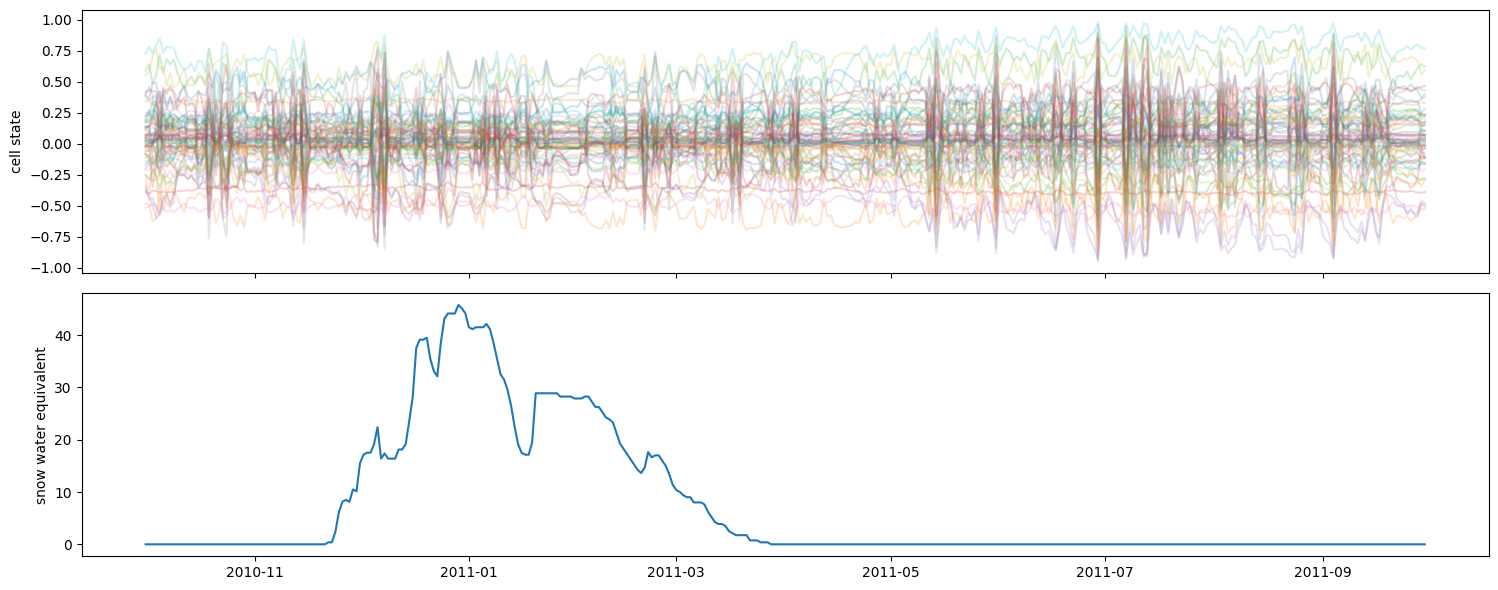

In [103]:
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(15, 6), sharex=True)

ax2.plot(date_range, swe)
ax.plot(date_range, cell_states, alpha=.2)

ax.set_ylabel('cell state')
ax2.set_ylabel('snow water equivalent')

plt.tight_layout()
plt.show()

In [ ]:
f, ax = plt.subplots(4, 2, figsize=(20, 14), sharex=True)
ax[0,0].set_title('Input values')
lines = ax[0,0].plot(swe)  # observed swe values
ax[0,0].legend(lines, cudalstm_config.dynamic_inputs, frameon=False)

ax[1,0].set_title('Cell state')
ax[1,0].plot(customlstm_output[0]['c_n'][0])

ax[0,1].set_title('Hidden state')
ax[0,1].plot(customlstm_output[0]['h_n'][0])

ax[1,1].set_title('Output gate')
ax[1,1].plot(customlstm_output[0]['o'][0])

ax[2,0].set_title('Forget gate')
ax[2,0].plot(customlstm_output[0]['f'][0])

ax[2,1].set_title('Input gate')
ax[2,1].plot(customlstm_output[0]['i'][0])

ax[3,0].set_title('Cell input activation')
ax[3,0].plot(customlstm_output[0]['g'][0])

f.delaxes(ax[3,1])
plt.tight_layout()